# Using Convolutional Neural Networks

Welcome to the first week of the first deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

## Introduction to this week's task: 'Dogs vs Cats'

We're going to try to create a model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if we can beat 80%, then we will be at the cutting edge as of 2013!

## Basic setup

There isn't too much to do to get started - just a few simple configuration steps.

This shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [2]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [32]:
path = "data/kaggle/"
#path = "data/kaggle/sample/"
results_path='data/kaggle/results/'
test_path = 'data/kaggle/test/'
valid_path=path + 'valid/'

A few basic libraries that we'll need for the initial exercises:

In [4]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [23]:
import utils; reload(utils)
from utils import plots

# Use a pretrained VGG model with our **Vgg16** class

Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

We have created a python class, *Vgg16*, which makes using the VGG 16 model very straightforward. 

## The punchline: state of the art custom model in 7 lines of code

Here's everything you need to do to get >97% accuracy on the Dogs vs Cats dataset - we won't analyze how it works behind the scenes yet, since at this stage we're just going to focus on the minimum necessary to actually do useful work.

In [6]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=32

In [7]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [10]:
vgg = Vgg16()

In [101]:
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 22998 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
22998/22998 [==============================] - 16729s - loss: 0.1276 - acc: 0.9694 - val_loss: 0.0965 - val_acc: 0.9800


In [104]:
vgg.model.save_weights(results_path+'ft00.h5')

In [ ]:
no_of_epochs=3

In [ ]:
vgg.model.optimizer.lr = 0.01

In [ ]:
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

In [11]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [14]:
print (preds[:5])

filenames = batches.filenames
print (filenames[:5])

[[  3.6067e-11   1.0000e+00]
 [  2.4672e-06   1.0000e+00]
 [  1.0000e+00   1.3160e-12]
 [  9.0795e-16   1.0000e+00]
 [  1.0000e+00   1.9237e-09]]
['unknown/6428.jpg', 'unknown/6978.jpg', 'unknown/4532.jpg', 'unknown/9263.jpg', 'unknown/11455.jpg']


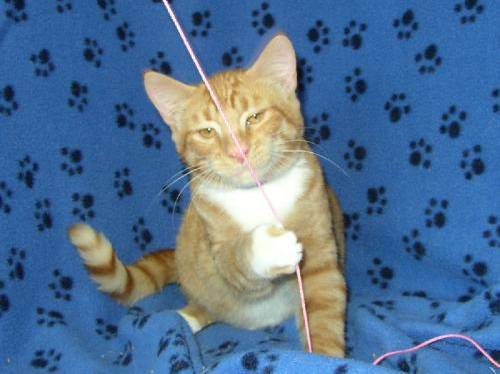

In [17]:
from PIL import Image
Image.open(test_path + filenames[2])

In [27]:
utils.save_array(results_path + 'test_preds.dat', preds)
utils.save_array(results_path + 'filenames.dat', filenames)

In [29]:
vgg.model.load_weights(results_path+'ft00.h5')

In [ ]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [ ]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [ ]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

In [ ]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

In [ ]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

In [ ]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print("Found %d confident correct cats labels" % len(correct_cats))
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

In [ ]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print("Found %d confident correct dogs labels" % len(correct_dogs))
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

In [ ]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print("Found %d incorrect cats" % len(incorrect_cats))
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

In [ ]:
4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print("Found %d incorrect dogs" % len(incorrect_dogs))
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

In [ ]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

In [ ]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [ ]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [ ]:
#Grab the dog prediction column
isdog = preds[:,1]
print("Raw Predictions: " + str(isdog[:5]))
print("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

In [ ]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
class_labels = [0,1] # 0=cats, 1=dogs
x = [1-(i*.0001) for i in range(1,10000)]  # probability of a dog
y = [log_loss(y_true=[1],y_pred=[[i*.0001,1-(i*.0001)]],eps=1e-15,labels=[0,1]) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [ ]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [ ]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [ ]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

In [ ]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

In [ ]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/redux/'+submission_file_name)